<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Authors:_ Joseph Nelson (DC), Boom Devahastin Na Ayudhya (NYC), Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA #, ARMA, AR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
# data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


---

## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [81]:
data['Date'] = pd.to_datetime(data['Date'])

In [82]:
data.set_index('Date', inplace=True)

In [83]:
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [84]:
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [85]:
data.shape

(421570, 4)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


Good News. There are no missing values.

---

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


Aggregation: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

In [87]:
data['Store'].value_counts()

13    10474
10    10315
4     10272
1     10244
2     10238
24    10228
27    10225
34    10224
20    10214
6     10211
32    10202
19    10148
31    10142
28    10113
41    10088
11    10062
23    10050
14    10040
40    10017
15     9901
8      9895
39     9878
17     9864
18     9859
26     9854
25     9804
7      9762
12     9705
22     9688
45     9637
21     9582
35     9528
29     9455
16     9443
3      9036
5      8999
9      8867
38     7362
37     7206
44     7169
30     7156
42     6953
43     6751
33     6487
36     6222
Name: Store, dtype: int64

In [88]:
Weekly_Sales = data[data['Store']==1]

In [89]:
Weekly_Sales.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [90]:
Weekly_Sales.shape

(10244, 4)

In [91]:
Weekly_Sales = Weekly_Sales.groupby(['Date'])[['Weekly_Sales']].sum() # the brackets are very important
Weekly_Sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [92]:
Weekly_Sales

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68
...,...
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81


---

#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

I will use the code created by Matthew Garton in the GA notes.

In [93]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

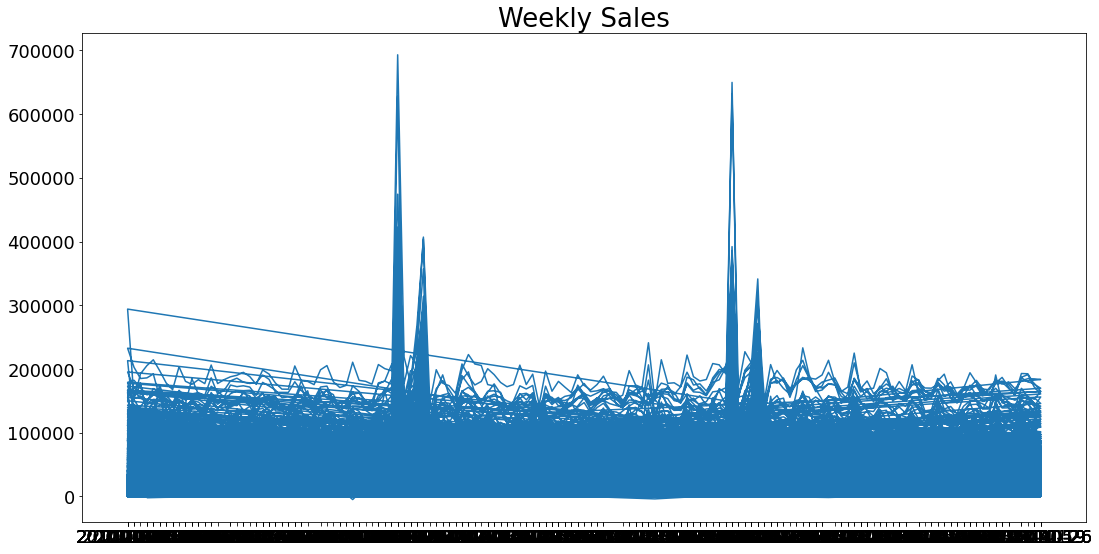

In [94]:
# Generate a time plot of our data.
plot_series(data, ['Weekly_Sales'], title = "Weekly Sales", steps=1000)

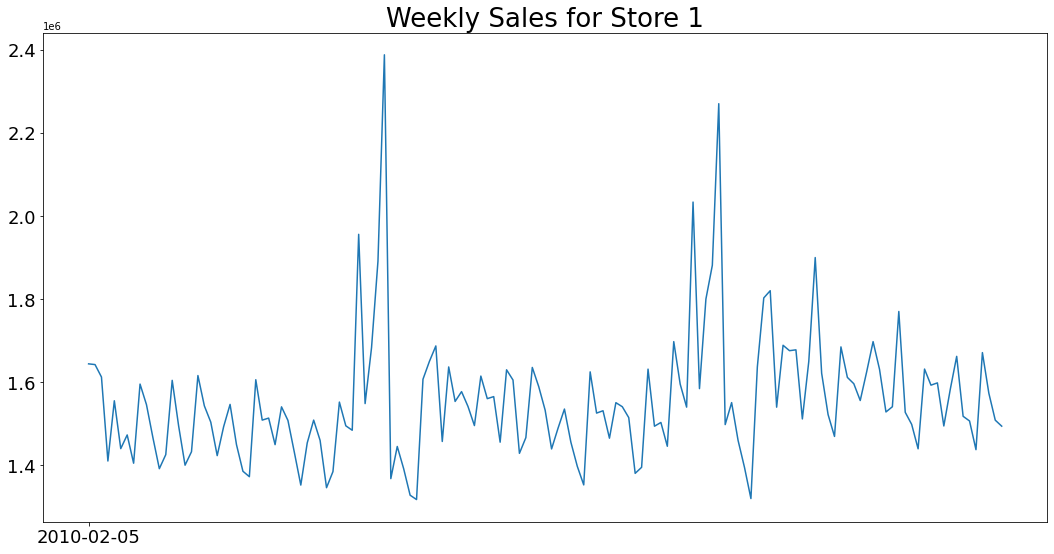

In [95]:
plot_series(Weekly_Sales, ['Weekly_Sales'], title = "Weekly Sales for Store 1", steps=1000)

Wah super messy plot. I will try resampling by month.

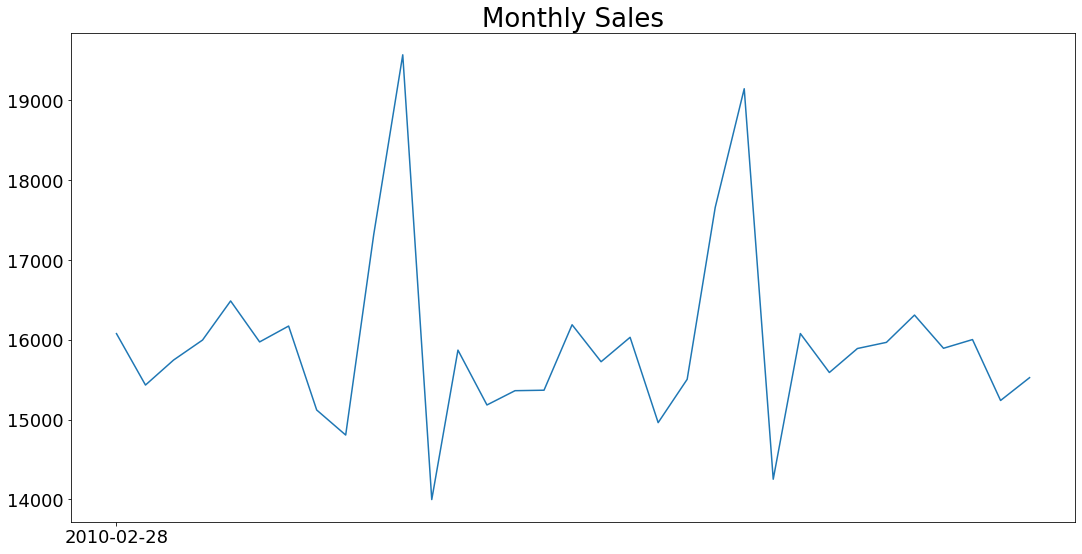

In [96]:
# Generate a Monthly time plot of our data.
plot_series(data.resample('M').mean(), cols=['Weekly_Sales'], title='Monthly Sales', steps=50)

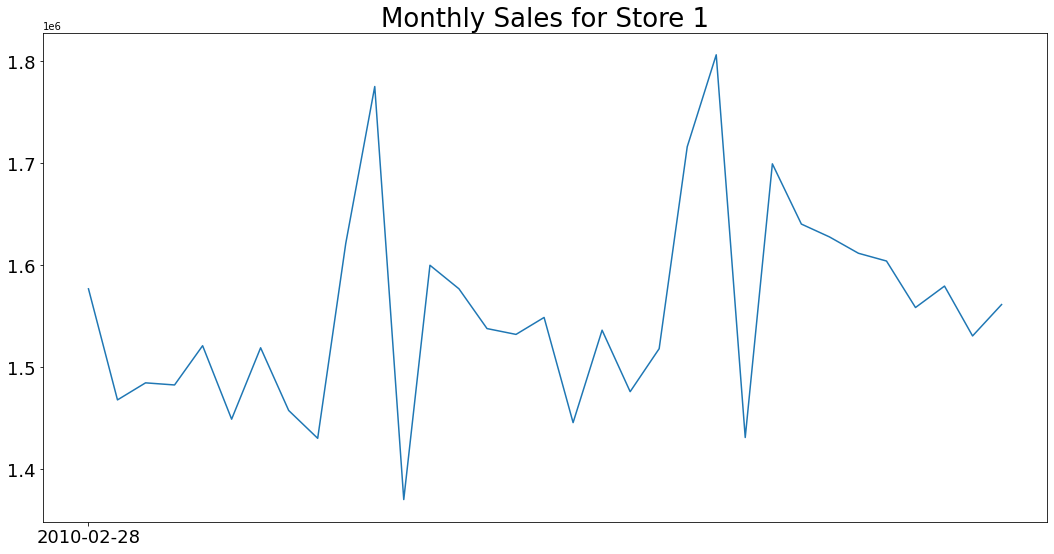

In [97]:
# Generate a Monthly time plot of our data.
plot_series(Weekly_Sales.resample('M').mean(), cols=['Weekly_Sales'], title='Monthly Sales for Store 1', steps=50)

Looks better 

Definitely lacks stationarity

---

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

Four Week Rolling Mean

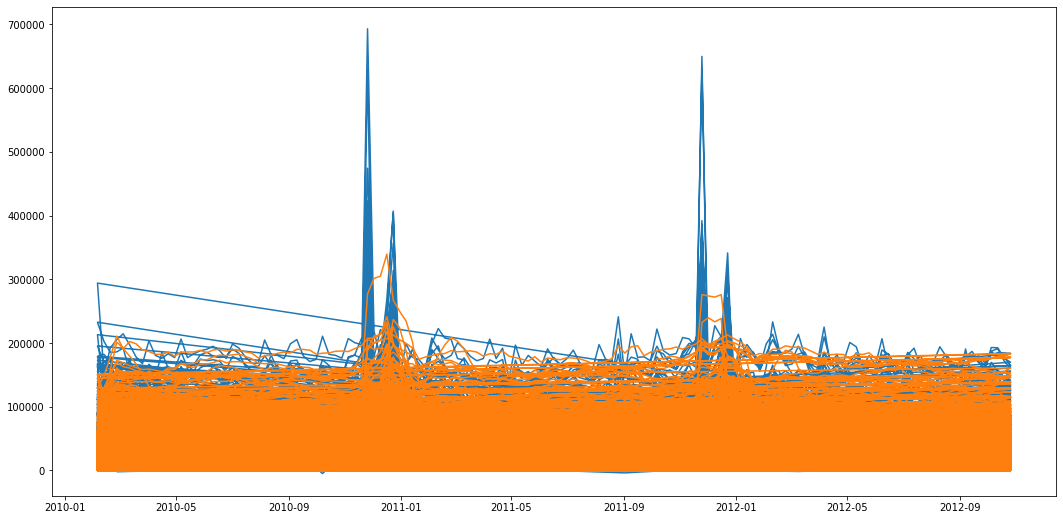

In [98]:
plt.figure(figsize=(18,9))
plt.plot(data['Weekly_Sales'])
plt.plot(data['Weekly_Sales'].rolling(4).mean())

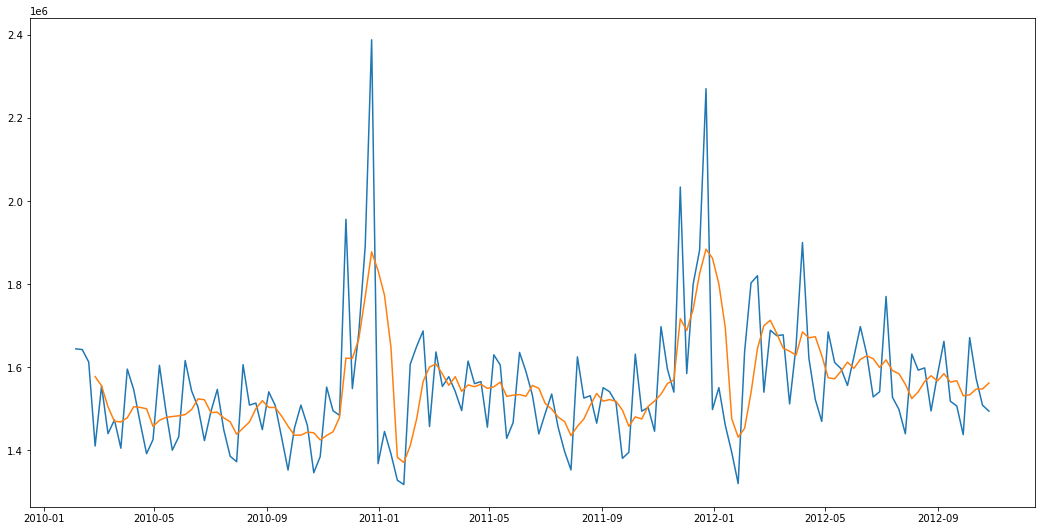

In [99]:
plt.figure(figsize=(18,9))
plt.plot(Weekly_Sales['Weekly_Sales'])
plt.plot(Weekly_Sales['Weekly_Sales'].rolling(4).mean())

Quarterly Rolling Mean (12 Weeks)

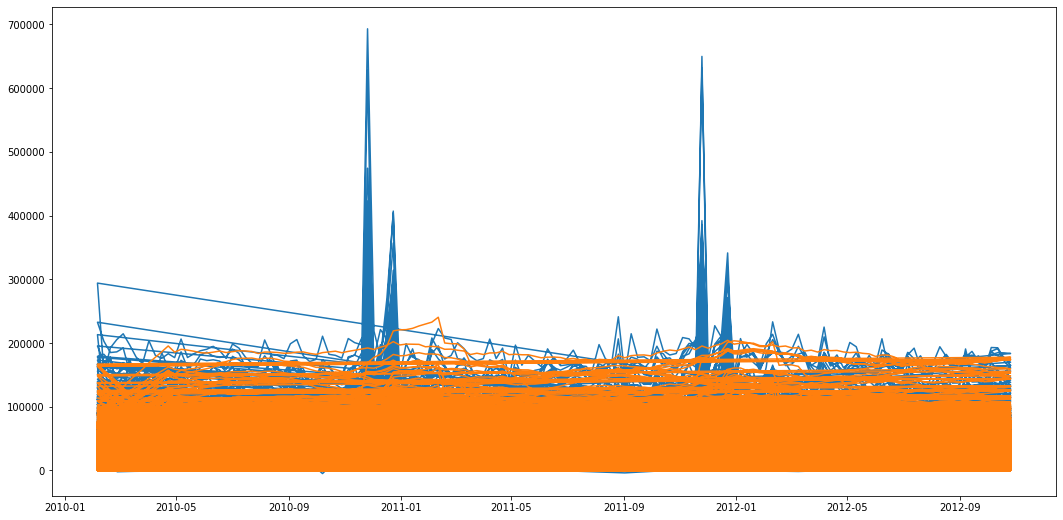

In [100]:
plt.figure(figsize=(18,9))
plt.plot(data['Weekly_Sales'])
plt.plot(data['Weekly_Sales'].rolling(12).mean())

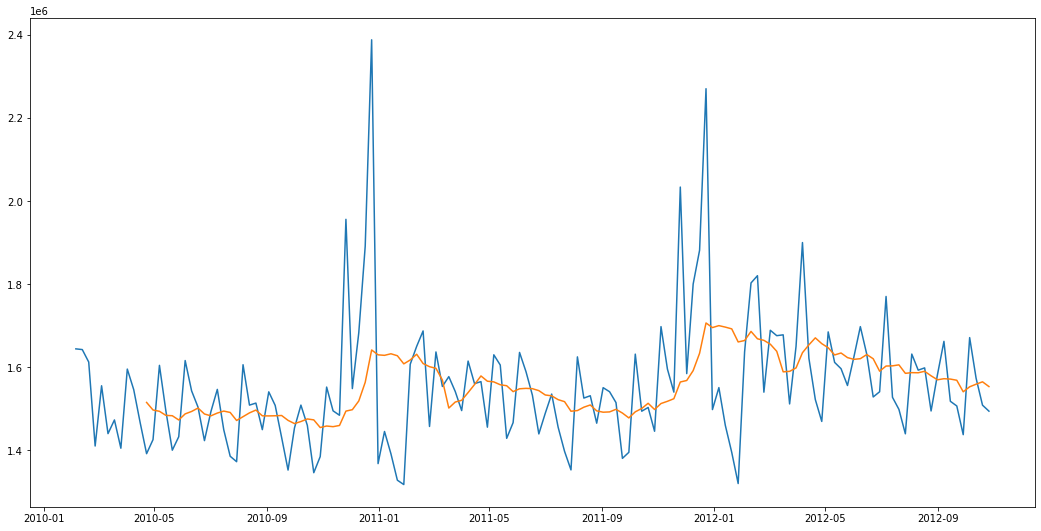

In [101]:
plt.figure(figsize=(18,9))
plt.plot(Weekly_Sales['Weekly_Sales'])
plt.plot(Weekly_Sales['Weekly_Sales'].rolling(12).mean())

Annual Rolling Mean (52 Weeks)

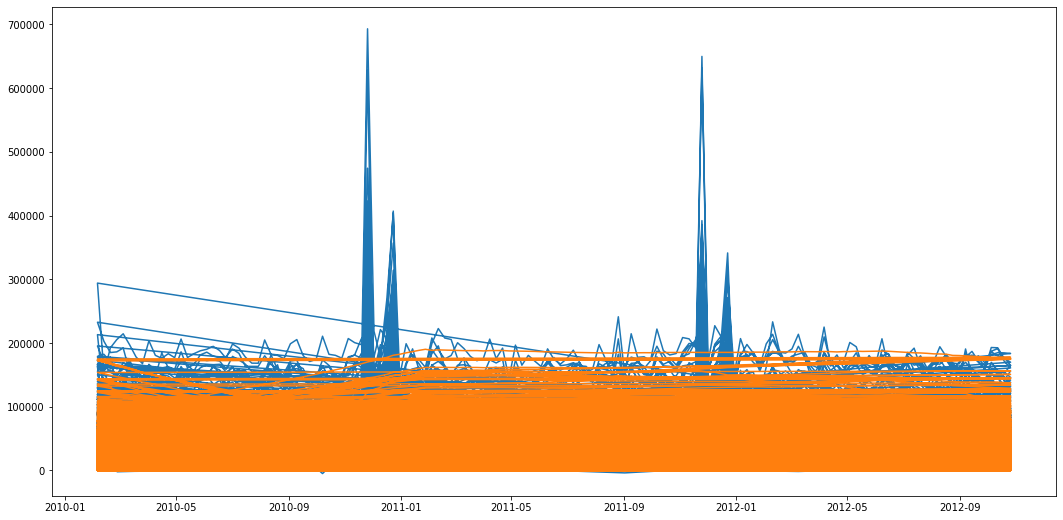

In [102]:
plt.figure(figsize=(18,9))
plt.plot(data['Weekly_Sales'])
plt.plot(data['Weekly_Sales'].rolling(52).mean())

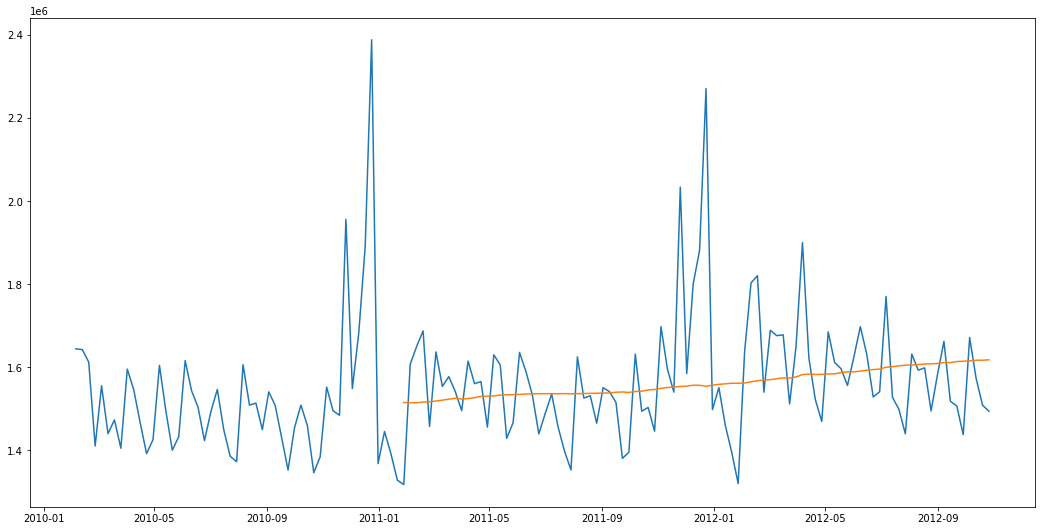

In [103]:
plt.figure(figsize=(18,9))
plt.plot(Weekly_Sales['Weekly_Sales'])
plt.plot(Weekly_Sales['Weekly_Sales'].rolling(52).mean())

My plots are terrible. Let me try again.

Alamak I used 'data' instead of the 'Weekly_Sales' dataframe. No wonder it was such a mess.

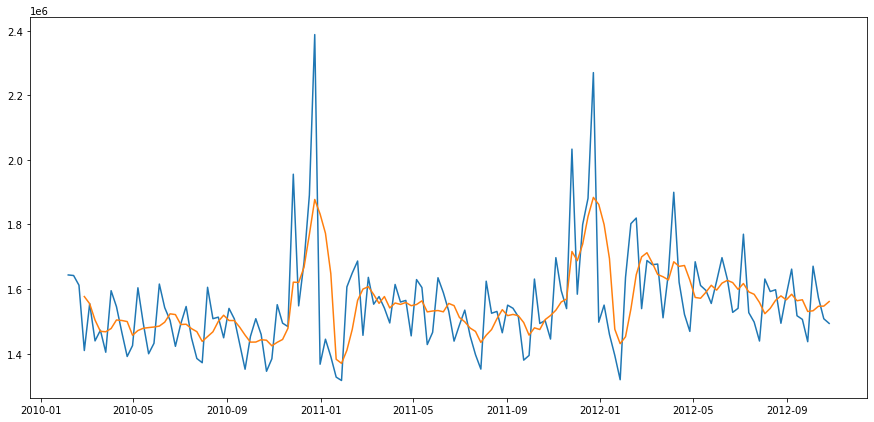

In [104]:
plt.figure(figsize=(15, 7))

plt.plot(Weekly_Sales.Weekly_Sales, label='Weekly Sales')
plt.plot(Weekly_Sales.Weekly_Sales.rolling(4).mean());

I went back and added to correct plots to my notebook

---

**2c. What can you say about trends in the data based on the rolling mean plot above?**

*Answer:* It is a sideways trend. There is no defineable increase or decrease. There is however a sharp increase in sales at the end of the year.

---

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

ACF = Correlation of the time series with it's own lag

In [105]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

1 Week Lag

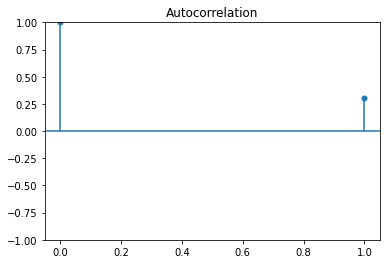

In [106]:
plot_acf(Weekly_Sales['Weekly_Sales'], lags = 1);


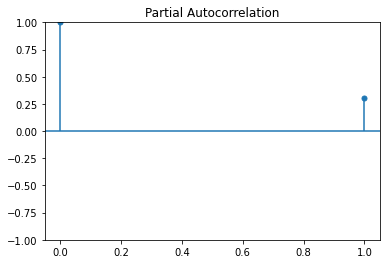

In [107]:
plot_pacf(Weekly_Sales['Weekly_Sales'], lags = 1);


2 Week Lag

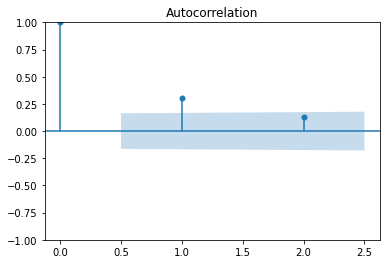

In [108]:
plot_acf(Weekly_Sales['Weekly_Sales'], lags = 2);


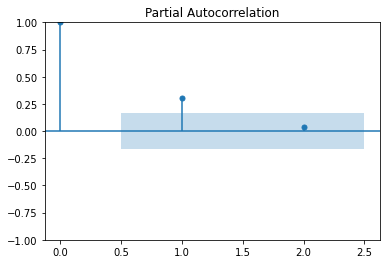

In [109]:
plot_pacf(Weekly_Sales['Weekly_Sales'], lags = 2);


52 Week Lag

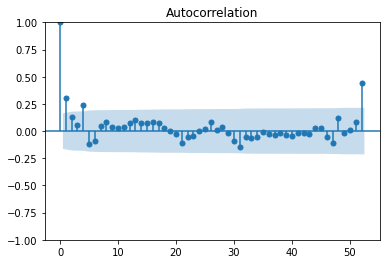

In [110]:
plot_acf(Weekly_Sales['Weekly_Sales'], lags = 52);


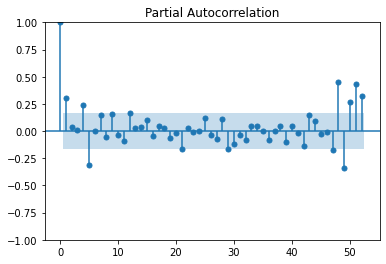

In [111]:
plot_pacf(Weekly_Sales['Weekly_Sales'], lags = 52);


**3b. What can you say about the series based on these autocorrelations?**

Answer:

I am still unable to interpret ACF and PACF. I am just going to copy paste the stuff from the notes since the interpretation is similar.

My guess is that based on the Lag-52 PACF plot,, there is a sharp cut off between lags 0 and 1, and 1 and 2. Also, the first lag value of the Lag-52 ACF plot is positive.

"If your PACF has a sharp cut-off and the first lag of your ACF (autocorrelation function) value is positive, choose an $AR(p)$ term where $p$ is the lag in the PACF after the cut-off." Thus, I will fit an $AR(1)$ model and an $AR(2)$ model and see how well they perform.

Time Series Talk : Autocorrelation and Partial Autocorrelation

https://www.youtube.com/watch?v=DeORzP0go5I

Auto regression using ACF and PACF | How to decide AR order using ACF and PACF

https://www.youtube.com/watch?v=52z_3wYz7XU

---

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

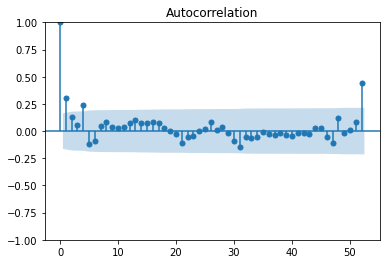

In [112]:
plot_acf(Weekly_Sales['Weekly_Sales'], lags = 52);

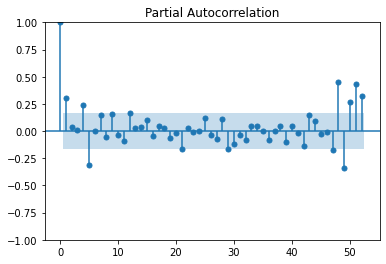

In [113]:
plot_pacf(Weekly_Sales['Weekly_Sales'], lags = 52);

---

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer:

My best guess is that the sales data are correlated every 52 weeks, which means there is possible seasonality/repeated trends.

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer: Same as above. I will copy paste.

I am still unable to interpret ACF and PACF. I am just going to copy paste the stuff from the notes since the interpretation is similar.

My guess is that based on the Lag-52 PACF plot,, there is a sharp cut off between lags 0 and 1, and 1 and 2. Also, the first lag value of the Lag-52 ACF plot is positive.

"If your PACF has a sharp cut-off and the first lag of your ACF (autocorrelation function) value is positive, choose an $AR(p)$ term where $p$ is the lag in the PACF after the cut-off." Thus, I will fit an $AR(1)$ model and an $AR(2)$ model and see how well they perform.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [114]:
Weekly_Sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [115]:
Weekly_Sales.shape

(143, 1)

In [116]:
Weekly_Sales.shape[0]*(4/5)

114.4

Index 114 will give us the 80th percentile of rows

In [117]:
# Set training data to be first 80% of rows.
train = Weekly_Sales.iloc[0:114]

# Set testing data to be last 20% of rows.
test = Weekly_Sales.iloc[114:] 

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. In each section, we will add additional ARIMA parameters in an effort to improve our modeling. Note that sometimes the model you attempt is not effective or the best -- try the BONUS sections below to see other approaches to modeling this dataset!

- Note that this is the same thing as an `ARIMA(1,0,0)` model.
- Pass in the Weekly Sales as an `ndarray`, not a `Series`.
- Pass in the training index using the ARIMA `dates` parameter.

**6a. Instantiate and fit an `AR(1)` model.**

In [118]:
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

I just copy paste from the lecture notebook

In [119]:
# Instantiate an AR(1) model on training data.
# Note this training data consists of the 
# time periods 0 through 143.
ar1 = ARIMA(endog = train['Weekly_Sales'],
            order = (1, 0, 0)) # (p, d, q)

# Fit AR(1) model.
model = ar1.fit()

In [120]:
# Generate predictions based on test set.
# Start at time period 114 and end at 143.
preds = model.predict(start=114, end=142)

In [121]:
preds.shape

(29,)

In [122]:
test.shape

(29, 1)

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [123]:
# Evaluate predictions.
mean_squared_error(test['Weekly_Sales'], preds)

6807103438.158344

In [124]:
mean_absolute_error(test['Weekly_Sales'], preds)

68274.49195084856

In [125]:
test['Weekly_Sales'].mean()

1571676.4934482758

**6c. How effective do you think this `AR(1)` model is?**

Answer: Not really sure. How to tell? My guess is that the mean absolute error is a large margin compared to the mean of the Weekly Sales data. So the model is not good.

---

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

In [126]:
test

,Weekly_Sales
Date,
2012-04-13,1621031.70
2012-04-20,1521577.87
2012-04-27,1468928.37
2012-05-04,1684519.99
2012-05-11,1611096.05
2012-05-18,1595901.87
2012-05-25,1555444.55
2012-06-01,1624477.58
2012-06-08,1697230.96


In [127]:
preds

2012-04-13    1.662558e+06
2012-04-20    1.586734e+06
2012-04-27    1.562488e+06
2012-05-04    1.554734e+06
2012-05-11    1.552255e+06
2012-05-18    1.551462e+06
2012-05-25    1.551209e+06
2012-06-01    1.551128e+06
2012-06-08    1.551102e+06
2012-06-15    1.551093e+06
2012-06-22    1.551091e+06
2012-06-29    1.551090e+06
2012-07-06    1.551090e+06
2012-07-13    1.551089e+06
2012-07-20    1.551089e+06
2012-07-27    1.551089e+06
2012-08-03    1.551089e+06
2012-08-10    1.551089e+06
2012-08-17    1.551089e+06
2012-08-24    1.551089e+06
2012-08-31    1.551089e+06
2012-09-07    1.551089e+06
2012-09-14    1.551089e+06
2012-09-21    1.551089e+06
2012-09-28    1.551089e+06
2012-10-05    1.551089e+06
2012-10-12    1.551089e+06
2012-10-19    1.551089e+06
2012-10-26    1.551089e+06
Freq: W-FRI, Name: predicted_mean, dtype: float64

In [128]:
test['Predictions']=preds

In [129]:
test

,Weekly_Sales,Predictions
Date,,
2012-04-13,1621031.70,1.662558e+06
2012-04-20,1521577.87,1.586734e+06
2012-04-27,1468928.37,1.562488e+06
2012-05-04,1684519.99,1.554734e+06
2012-05-11,1611096.05,1.552255e+06
2012-05-18,1595901.87,1.551462e+06
2012-05-25,1555444.55,1.551209e+06
2012-06-01,1624477.58,1.551128e+06
2012-06-08,1697230.96,1.551102e+06


In [130]:
test['Redisuals']=test['Weekly_Sales']-test['Predictions']

In [131]:
test

,Weekly_Sales,Predictions,Redisuals
Date,,,
2012-04-13,1621031.70,1.662558e+06,-41526.588735
2012-04-20,1521577.87,1.586734e+06,-65156.274487
2012-04-27,1468928.37,1.562488e+06,-93559.253705
2012-05-04,1684519.99,1.554734e+06,129785.751128
2012-05-11,1611096.05,1.552255e+06,58841.134942
2012-05-18,1595901.87,1.551462e+06,44439.775975
2012-05-25,1555444.55,1.551209e+06,4235.978806
2012-06-01,1624477.58,1.551128e+06,73350.078584
2012-06-08,1697230.96,1.551102e+06,146129.382517


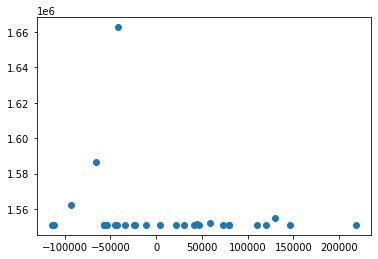

In [132]:
plt.scatter(test['Redisuals'],test['Predictions'])

plt.show()

Let me plot predictions

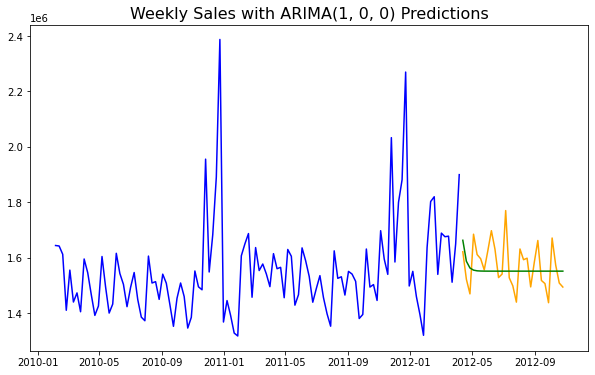

In [137]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, train['Weekly_Sales'], color = 'blue')

# Plot testing data.
plt.plot(test.index, test['Weekly_Sales'], color = 'orange')

# Plot predicted test values.
plt.plot(test.index, preds, color = 'green')

plt.title(label = 'Weekly Sales with ARIMA(1, 0, 0) Predictions', fontsize=16)
plt.show();

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer: Not Sure (KIV)

---

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [54]:
# Instantiate an AR(2) model on training data.
# Note this training data consists of the 
# time periods 0 through 143.
ar2 = ARIMA(endog = train['Weekly_Sales'],
            order = (2, 0, 0)) # (p, d, q)

# Fit AR(2) model.
model2 = ar2.fit()

In [55]:
preds2 = model2.predict(start=114, end=142)

Model 1 Predictions

In [56]:
mean_squared_error(test['Weekly_Sales'], preds)

6807103438.158344

Model 2 Predictions

In [57]:
mean_squared_error(test['Weekly_Sales'], preds2)

6905046173.25134

**8b. How did your results change?**

Answer: The error increased.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [58]:
# Instantiate an ARMA(2,2) model on training data.
# Note this training data consists of the 
# time periods 0 through 143.
arma22 = ARIMA(endog = train['Weekly_Sales'],
            order = (2, 0, 2)) # (p, d, q)

# Fit AR(2) model.
model3 = arma22.fit()

In [59]:
preds3 = model3.predict(start=114, end=142)

Model 3 Predictions

In [60]:
mean_squared_error(test['Weekly_Sales'], preds3)

6332171463.187716

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer: Decreased a lot. 

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [61]:
# Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# Define function to easily interpret results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Execute test on training data.
interpret_dftest(adfuller(train['Weekly_Sales']))

Test Statistic   -4.558245
p-value           0.000154
dtype: float64

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer: p-value is extremely small, thus the data is stationary

---

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [62]:
Weekly_Sales

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68
...,...
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81


In [63]:
Weekly_Sales['Diff 1'] = Weekly_Sales['Weekly_Sales'].diff()


In [64]:
Weekly_Sales

,Weekly_Sales,Diff 1
Date,,
2010-02-05,1643690.90,NaN
2010-02-12,1641957.44,-1733.46
2010-02-19,1611968.17,-29989.27
2010-02-26,1409727.59,-202240.58
2010-03-05,1554806.68,145079.09
...,...,...
2012-09-28,1437059.26,-69066.80
2012-10-05,1670785.97,233726.71
2012-10-12,1573072.81,-97713.16


In [65]:
Weekly_Sales['Diff 2'] = Weekly_Sales['Weekly_Sales'].diff(2)

In [66]:
Weekly_Sales['Diff 3'] = Weekly_Sales['Weekly_Sales'].diff(3)

In [67]:
Weekly_Sales['Diff 4'] = Weekly_Sales['Weekly_Sales'].diff(4)

In [68]:
Weekly_Sales.head(10)

,Weekly_Sales,Diff 1,Diff 2,Diff 3,Diff 4
Date,,,,,
2010-02-05,1643690.90,NaN,NaN,NaN,NaN
2010-02-12,1641957.44,-1733.46,NaN,NaN,NaN
2010-02-19,1611968.17,-29989.27,-31722.73,NaN,NaN
2010-02-26,1409727.59,-202240.58,-232229.85,-233963.31,NaN
2010-03-05,1554806.68,145079.09,-57161.49,-87150.76,-88884.22
2010-03-12,1439541.59,-115265.09,29814.00,-172426.58,-202415.85
2010-03-19,1472515.79,32974.20,-82290.89,62788.20,-139452.38
2010-03-26,1404429.92,-68085.87,-35111.67,-150376.76,-5297.67
2010-04-02,1594968.28,190538.36,122452.49,155426.69,40161.60


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

Diff 1

In [69]:
interpret_dftest(adfuller(Weekly_Sales['Diff 1'][1:]))

Test Statistic   -7.261575e+00
p-value           1.676180e-10
dtype: float64

Diff 2

In [70]:
interpret_dftest(adfuller(Weekly_Sales['Diff 2'][2:]))

Test Statistic   -6.206249e+00
p-value           5.648528e-08
dtype: float64

Diff 3

In [71]:
interpret_dftest(adfuller(Weekly_Sales['Diff 3'][3:]))

Test Statistic   -5.160622
p-value           0.000011
dtype: float64

Diff 4

In [148]:
interpret_dftest(adfuller(Weekly_Sales['Diff 4'][4:]))

Test Statistic   -6.856819e+00
p-value           1.640394e-09
dtype: float64

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer: All columns have small p-values. My guess is that there is no need to difference the data so much since difference of 1 is adequate.

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer: I am honestly not sure. What is going on here.

---

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [151]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_d = 0

# Use nested for loop to iterate over values of p and q.
for d in range(50):
        
    # Insert try and except statements.
    try:
            
        # Fitting an ARIMA(2, d, 2) model.
        print(f'Attempting ARIMA(2, {d}, 2)')
            
        # Instantiate ARIMA model.
        arima = ARIMA(endog=train['Weekly_Sales'], order=(2, d, 2))
            
            
        # Fit ARIMA model.
        model = arima.fit()

        # Print out AIC for ARIMA(p, 1, q) model.
        print(f'The AIC for ARIMA(2,{d},2) is: {model.aic}')

        # Is my current model's AIC better than our best_aic?
        if model.aic < best_aic:
                
            # If so, let's overwrite best_aic, best_p, and best_q.
            best_aic = model.aic
            best_d = d

    except:
        pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA(2,{best_d},2).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(2, 0, 2)
The AIC for ARIMA(2,0,2) is: 3050.687732542951
Attempting ARIMA(2, 1, 2)
The AIC for ARIMA(2,1,2) is: 3057.36210558412
Attempting ARIMA(2, 2, 2)
The AIC for ARIMA(2,2,2) is: 3080.279030141548
Attempting ARIMA(2, 3, 2)
The AIC for ARIMA(2,3,2) is: 3099.239750431718
Attempting ARIMA(2, 4, 2)
The AIC for ARIMA(2,4,2) is: 3139.267346247289
Attempting ARIMA(2, 5, 2)
The AIC for ARIMA(2,5,2) is: 3177.0608102798283
Attempting ARIMA(2, 6, 2)
The AIC for ARIMA(2,6,2) is: 3243.416697528678
Attempting ARIMA(2, 7, 2)
The AIC for ARIMA(2,7,2) is: 3311.310229242122
Attempting ARIMA(2, 8, 2)
The AIC for ARIMA(2,8,2) is: 3377.945496699085
Attempting ARIMA(2, 9, 2)
The AIC for ARIMA(2,9,2) is: 3444.2671480711297
Attempting ARIMA(2, 10, 2)
The AIC for ARIMA(2,10,2) is: 3511.497917280766
Attempting ARIMA(2, 11, 2)
The AIC for ARIMA(2,11,2) is: 3579.868722007449
Attempting ARIMA(2, 12, 2)
The AIC for ARIMA(2,12,2) is: 3650.2719010590713
Attempting ARIMA(2, 13, 2)
The AIC for ARIM

**11b. Interpret the results from the last answer.**


Answer: I did a gridsearch and the best ARIMA is ARIMA(2, 30, 2). No idea what to interpret.

---

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Just try. Copy paste from Lecture 8.04

16121958936.458729


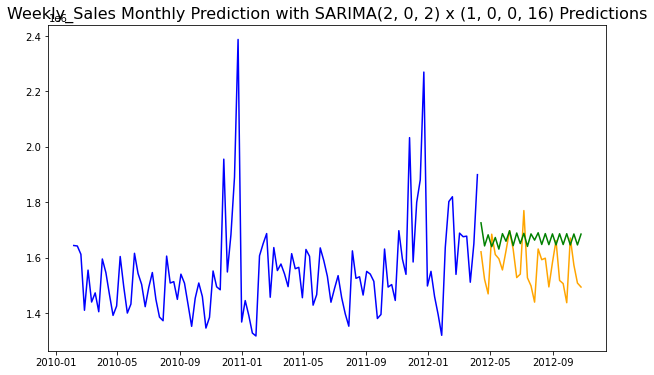

In [75]:
# Fit a SARIMA(1, 0, 0) x (1, 0, 0, 16) model.

sarima = SARIMAX(endog = train['Weekly_Sales'],
                 order = (2, 0, 2),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 16)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=114, end=142)

# Evaluate predictions.
print(mean_squared_error(test['Weekly_Sales'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['Weekly_Sales'], color = 'blue')
plt.plot(test['Weekly_Sales'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Weekly_Sales Monthly Prediction with SARIMA(2, 0, 2) x (1, 0, 0, 16) Predictions', fontsize=16)
plt.show();

First model is terrible

Let's try Grid Searching

In [76]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = train['Weekly_Sales'],
                                 order = (2, 0, 2),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 16)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 0 and end at 142.
                preds = model.predict(start=0, end=142)

                # Evaluate predictions.
                print(f'The MSE for (1, 0, 0)x({P},{D},{Q},16) is: {mean_squared_error(train["Weekly_Sales"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(train["Weekly_Sales"], preds):
                    mse = mean_squared_error(train["Weekly_Sales"], preds)
                    final_P = P
                    final_D = D
                    final_Q = Q
                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},16).')
print(f'This model has an MSE of {mse}.')

Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,16).
This model has an MSE of 990000000000000000.


Fit the best model

16242244036.285515


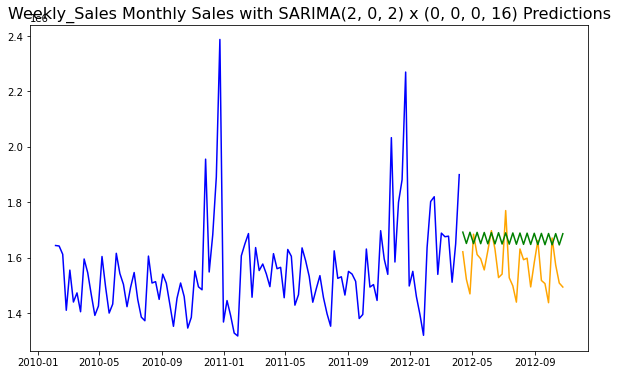

In [77]:

# Fit and visualize a SARIMA(2, 0, 2) x (0, 0, 0, 16) model.

sarima = SARIMAX(endog = train['Weekly_Sales'],
                 order = (2, 0, 2),              # (p, d, q)
                 seasonal_order = (0, 0, 0, 16)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 114 and end at 142.
preds = model.predict(start=114, end=142)

# Evaluate predictions.
print(mean_squared_error(test['Weekly_Sales'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['Weekly_Sales'], color = 'blue')
plt.plot(test['Weekly_Sales'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Weekly_Sales Monthly Sales with SARIMA(2, 0, 2) x (0, 0, 0, 16) Predictions', fontsize=16)
plt.show();

**12b. How did your best SARIMAX model perform?**

Answer: Still no good. It is either i didnt do it well or this is really the model.

Let me try again by tweaking S.

In [78]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(5):
    for Q in range(5):
        for D in range(5):
            for S in range(5):
                try:
                    # Instantiate SARIMA model.
                    sarima = SARIMAX(endog = train['Weekly_Sales'],
                                    order = (2, 0, 2),              # (p, d, q)
                                    seasonal_order = (P, D, Q, S)) # (P, D, Q, S)

                    # Fit SARIMA model.
                    model = sarima.fit()

                    # Generate predictions based on training set.
                    # Start at time period 0 and end at 142.
                    preds = model.predict(start=0, end=142)

                    # Evaluate predictions.
                    print(f'The MSE for (1, 0, 0)x({P},{D},{Q},{S}) is: {mean_squared_error(train["Weekly_Sales"], preds)}')
                    
                    # Save for final report.
                    if mse > mean_squared_error(train["Weekly_Sales"], preds):
                        mse = mean_squared_error(train["Weekly_Sales"], preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S
                    
                except:
                    pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(2, 0, 2)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {mse}.')

Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,0).
This model has an MSE of 990000000000000000.


Ignore the above string, it should be SARIMA(2,0,2)x(0,0,0,0)

16242244036.285515


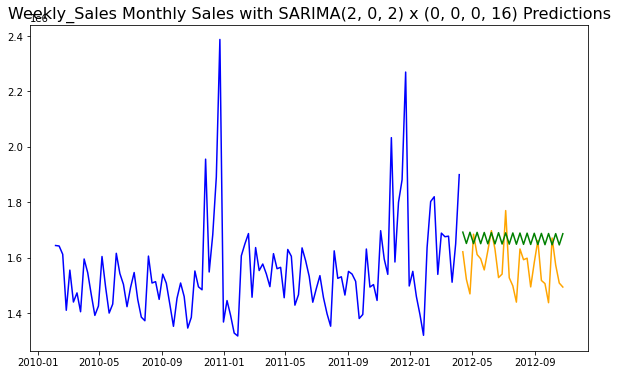

In [79]:
# Fit and visualize a SARIMA(2, 0, 2) x (0, 0, 0, 0) model.

sarima = SARIMAX(endog = train['Weekly_Sales'],
                 order = (2, 0, 2),              # (p, d, q)
                 seasonal_order = (0, 0, 0, 0)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 114 and end at 142.
preds = model.predict(start=114, end=142)

# Evaluate predictions.
print(mean_squared_error(test['Weekly_Sales'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['Weekly_Sales'], color = 'blue')
plt.plot(test['Weekly_Sales'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Weekly_Sales Monthly Sales with SARIMA(2, 0, 2) x (0, 0, 0, 16) Predictions', fontsize=16)
plt.show();

This seems like the best

---

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

Answer: I will go with the SARIMA Model. Will wait for the explanation. I am very unclear with this topic.

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: 

**13c. How might you improve it?**

Answer:

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: